In [1]:
import numpy as np
import matplotlib.pyplot as plt

This script constructs the ground state of the AKLT model (spin-1 chain) 
and represents it as a Matrix Product State (MPS). 
It then computes the entanglement entropy (Von Neumann entropy) across every bond in the chain
for several chain lengths N.

Von Neumann entropy $$S=-\sum_i\tilde{s}^2_i\log\tilde{s}^2_i$$ 
with $$\tilde{s}^2_i=\frac{s^2_i}{\sum_j s^2_j}$$ where $$s_i$$ are the singular values found doing the SVD

Main steps:
1. Define spin-1 operators (X, Y, Z)
2. Build the AKLT Hamiltonian for a chain of N spins
3. Diagonalize the Hamiltonian to get the degenerate ground space
4. Convert one ground state to MPS via successive SVDs
5. Compute von Neumann entanglement entropy from the singular values
6. Plot the entropy profiles for each N


In [2]:
#Usual AKLT Hamiltonian implementation using the tensor products 

# Define spin-1 operators
X = np.sqrt(1/2) * np.array([[0, 1, 0],
                             [1, 0, 1],
                             [0, 1, 0]], dtype=np.complex128)

Y = (-1j * np.sqrt(1/2) * np.array([[0, 1, 0],
                                    [-1, 0, 1],
                                    [0, -1, 0]], dtype=np.complex128))

Z = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, -1]], dtype=np.complex128)

def construct_chain(N, operator, pos):
    """
    Embed the given operator at positions `pos` and `pos + 1` in an N-spin chain.
    All other positions are filled with identity matrices.

    This effectively constructs the operator acting on a many-body Hilbert space
    via Kronecker products (tensor product of matrices).

    Parameters:
        N (int): Number of spins in the chain.
        operator (np.ndarray): Operator to embed (e.g., X, Y, Z).
        pos (int): The starting position for the operator (acting on spins pos and pos + 1).

    Returns:
        np.ndarray: The resulting full-chain matrix.
    """
    a_chain = [np.eye(3, dtype=np.complex128) for _ in range(N)]
    a_chain[pos] = operator
    a_chain[pos + 1] = operator
    result = a_chain[0]
    for ii in range(1, N):
        result = np.kron(result, a_chain[ii])
    return result

def scalar_product(N, i):
    """
    Compute the scalar product S_i · S_{i+1} = X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1}
    acting on spins i and i+1 in a full N-site Hilbert space.
    """
    return (
        construct_chain(N, X, i) +
        construct_chain(N, Y, i) +
        construct_chain(N, Z, i)
    )

def Hamiltonian(N):
    """
    Construct the AKLT Hamiltonian for an N-spin chain:
    H = Σ_i [ S_i · S_{i+1} + (1/3)*(S_i · S_{i+1})² ]

    The AKLT Hamiltonian is built using nearest-neighbor interactions.
    """
    H = np.zeros((3**N, 3**N), dtype=np.complex128)
    for ii in range(N - 1):
        SdotS = scalar_product(N, ii)
        H += SdotS + (1/3)*(SdotS @ SdotS)
    return H

In [3]:
#Implementation of the MPS decomposition

def split(M, bond_dim):
    """
    Split a matrix M via SVD and truncate to at most `bond_dim` singular values.

    The input M is expected to be reshaped as a bipartition of a wavefunction.
    The output is reshaped U, S, V matrices used for constructing the MPS tensors.
    """
    print("Initial shape M........:",  M.shape)
    U, S, Vd = np.linalg.svd(M, full_matrices=False)
    bonds = len(S)
    print("U shape", U.shape)
    print("bond dimension:", bonds)
    print("V shape", Vd.shape)

    # Reshape for MPS construction
    Vd = Vd.reshape(bonds, local_dim, -1)
    U = U.reshape((-1, local_dim, bonds))
    print("there is a reshape")
    print("U shape", U.shape)
    print("V shape", Vd.shape)

    chi = np.min([bonds, bond_dim])
    U, S, Vd = U[:, :, :chi], S[:chi], Vd[:chi]
    return U, S, Vd

def statevector_to_mps(psi):
    """
    Decompose a full quantum state vector into a left-canonical MPS using SVD.

    Parameters:
        psi: The full statevector of the system (shape 3^N).

    Returns:
        Ms: List of MPS tensors (one per site).
        Ss: List of singular value vectors (entanglement spectrum across each bond).
    """
    Ms = []
    Ss = []

    # First split
    psi = np.reshape(psi, (local_dim, -1))
    U, S, Vd = split(psi, bond_dim)
    Ms.append(U)
    Ss.append(S)
    bondL = Vd.shape[0]
    print("bondL: ", bondL)
    psi = np.tensordot(np.diag(S), Vd, 1)
    print("primer psi shape: ", psi.shape)

    # Recursively SVD the remaining sites
    for _ in range(N-2):
        psi = np.reshape(psi, (local_dim*bondL, -1))
        print("psi: for i:", _, "shape", psi.shape)
        U, S, Vd = split(psi, bond_dim)
        Ms.append(U)
        Ss.append(S)
        psi = np.tensordot(np.diag(S), Vd, 1)
        bondL = Vd.shape[0]

    # Final dummy site
    psi = np.reshape(psi, (-1, 1))
    U, _, _ = np.linalg.svd(psi, full_matrices=False)
    U = np.reshape(U, (-1, local_dim, 1))
    Ms.append(U)

    Ms = [np.asarray(tensor) for tensor in Ms]
    Ss = [np.asarray(s) for s in Ss]

    return Ms, Ss



In [4]:
#Some checks and the calculation of the entropy
def check_left_isometry(Ms):
    """
    Check if MPS is in left-canonical form by verifying:
    For each tensor (except last), U†U = I

    Returns:
        List of tuples (site index, isometry status)
    """
    results = []
    for i, tensor in enumerate(Ms[:-1]):
        chiL, d, chiR = tensor.shape
        print(tensor.shape)
        U = tensor.reshape(-1, chiR)
        is_iso = np.allclose(U.conj().T @ U, np.eye(chiR), atol=1e-10)
        results.append((i, is_iso))
    return results

def entanglement_entropy(singular_values, eps=0.02):
    """
    Compute von Neumann entropy from singular values of each bond.

    Parameters:
        singular_values: list of arrays of singular values
        eps: numerical cutoff to avoid log(0) issues

    Returns:
        List of entropies across bonds
    """
    entropies = []
    for vec in singular_values:
        s = np.asarray(vec)
        s_sq = s**2
        s_sq = s_sq / np.sum(s_sq)
        s_sq = s_sq[s_sq > eps]  # avoid numerical log(0)
        print(s_sq)
        if len(s_sq) == 0:
            entropy = 0.0
        else:
            entropy = -np.sum(s_sq * np.log(s_sq))
        entropies.append(entropy)
    return entropies               

Initial shape M........: (3, 3)
U shape (3, 3)
bond dimension: 3
V shape (3, 3)
there is a reshape
U shape (1, 3, 3)
V shape (3, 3, 1)
bondL:  3
primer psi shape:  (3, 3, 1)
(1, 3, 3)
Tensor 0: Isometry
Norm of the quantum state is 1! (0.9999999999999998+0j)
[0.5 0.5]
entropy: [0.6931471805599453]
Initial shape M........: (3, 9)
U shape (3, 3)
bond dimension: 3
V shape (3, 9)
there is a reshape
U shape (1, 3, 3)
V shape (3, 3, 3)
bondL:  3
primer psi shape:  (3, 3, 3)
psi: for i: 0 shape (9, 3)
Initial shape M........: (9, 3)
U shape (9, 3)
bond dimension: 3
V shape (3, 3)
there is a reshape
U shape (3, 3, 3)
V shape (3, 3, 1)
(1, 3, 3)
(3, 3, 3)
Tensor 0: Isometry
Tensor 1: Isometry
Norm of the quantum state is 1! (0.9999999999999998+0j)
[0.71417615 0.28582381]
[0.71417615 0.28582381]
entropy: [0.5983699430044258, 0.5983699430044256]
Initial shape M........: (3, 27)
U shape (3, 3)
bond dimension: 3
V shape (3, 27)
there is a reshape
U shape (1, 3, 3)
V shape (3, 3, 9)
bondL:  3
primer

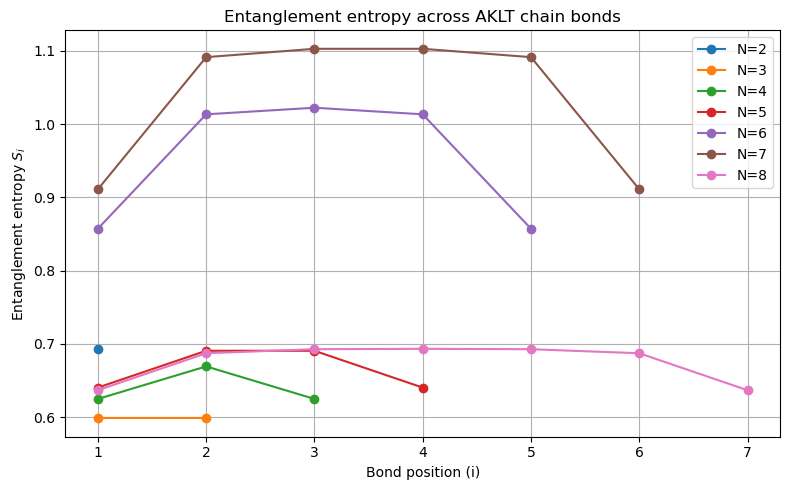

In [5]:
N_values = [2, 3, 4, 5, 6, 7, 8]  # Chain lengths to simulate

local_dim = 3     # spin-1 local Hilbert space
degeneracy = 4    # number of ground states expected from AKLT model
bond_dim = 100    # max number of Schmidt values to keep in MPS
entropy_profiles = {}

# Loop over different chain lengths
for N in N_values:
    H = Hamiltonian(N)  
    eigenvalues, eigenvectors = np.linalg.eigh(H)

    # Extract degenerate ground space
    ground_states = eigenvectors[:, :degeneracy]
    state = ground_states[:, 0]
    state = state/np.linalg.norm(state)

    # Convert statevector to MPS
    mps_vectors, mps_svalues = statevector_to_mps(state)

    # Verify isometric (left-canonical) form
    isometry_results = check_left_isometry(mps_vectors)
    for i, is_iso in isometry_results:
        print(f"Tensor {i}: {'Isometry' if is_iso else 'not isometry'}")

    # Check full norm is preserved
    norm = np.tensordot(mps_vectors[-1], mps_vectors[-1].conj(), ([0, 1, 2], [0, 1, 2]))
    if np.isclose(norm, 1):
        print("Norm of the quantum state is 1!", norm)
    else:
        print(f"Norm of the quantum state is {norm}")

    # Compute entanglement entropy across all internal bonds
    entropies = entanglement_entropy(mps_svalues)
    print("entropy:", entropies)

    entropy_profiles[N] = entropies



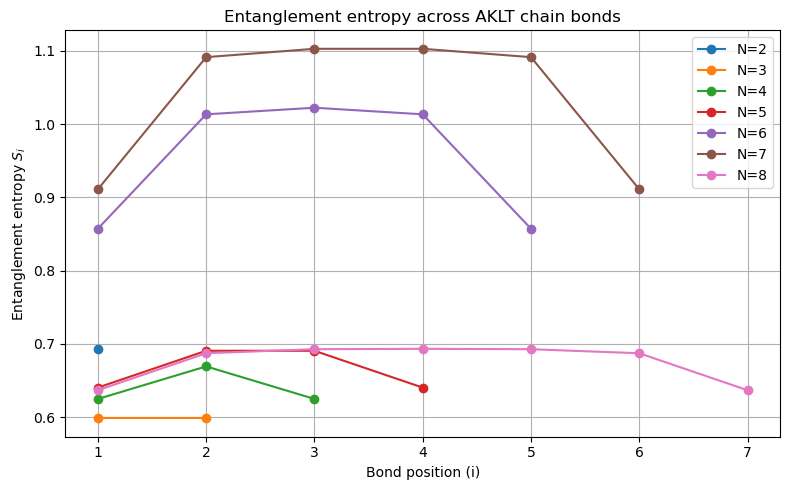

In [6]:
plt.figure(figsize=(8, 5))
for N, entropies in entropy_profiles.items():
    plt.plot(range(1, N), entropies, marker='o', label=f'N={N}')

plt.xlabel("Bond position (i)")
plt.ylabel("Entanglement entropy $S_i$")
plt.title("Entanglement entropy across AKLT chain bonds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()